# Plan

## 1. Cleaning and pre-process

### 1a. Drop non relevant columns and drop rows with less than 5% entries

### 1b. Split dataset in houses and apartments, delete outliers

### 1c. Impute missing values for each group

### 1d. Merge dataset back and feature engineering (Ordinal encoding for state of the building, one hot encoding for apartment type )


In [2]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim


In [4]:
houses = pd.DataFrame(pd.read_csv('houses.csv'))
apartments = pd.DataFrame(pd.read_csv('apartments.csv'))

In [5]:
properties_file = pd.read_csv('house_data_test.csv')
df = pd.concat([houses,apartments],axis=0)
print(df.head())
df.drop(['Unnamed: 0','terrace_surface','garden_surface','id','locality'],axis=1,inplace=True)
threshold = 0.05 * len(df)
print(df.columns)
columns_low_missing_data = df.columns[df.isna().sum() < threshold]
df.dropna(subset=columns_low_missing_data, inplace=True)
df.drop_duplicates(subset=['zip_code', 'latitude', 'longitude'], keep='first', inplace=True)
df_dummies = pd.get_dummies(df["property_type"])
df_dummies = pd.concat([df,df_dummies], axis=1)
df_dummies.drop('property_type', axis=1,inplace=True)


   Unnamed: 0   district   locality   latitude  longitude          id  \
0           0   Courtrai   Kortrijk  50.820027   3.293897  20362957.0   
1           1      Liège    Seraing  50.617542   5.500324  20363431.0   
2           2      Liège   FLÉMALLE  50.598644   5.417340  20366377.0   
3           3  Charleroi    Fleurus  50.444838   4.517772  20364877.0   
4           4      Liège  Montegnée  50.634941   5.513929  20363055.0   

   zip_code property_sub_type property_type     price  ...  nb_facades  \
0    8500.0             House         HOUSE  164500.0  ...         2.0   
1    4101.0             House         HOUSE  199000.0  ...         2.0   
2    4400.0             House         HOUSE  195000.0  ...         3.0   
3    6220.0             House         HOUSE  179000.0  ...         3.0   
4    4420.0             House         HOUSE  159000.0  ...         3.0   

   state_of_building  fireplace  equipped_kitchen garden  garden_surface  \
0               Good          0         

In [6]:
print(df_dummies.district.unique())

avg_monthly_income_dict = {
    'Anvers': 4.213,
    'Malines': 4.121,
    'Turnhout': 4.031,
    'Bruxelles': 4.748,
    'Hal-Vilvorde': 4.406,
    'Louvain': 4.347,
    'Nivelles': 4.272,
    'Bruges': 3.802,
    'Dixmude': 3.510,
    'Ypres': 3.564,
    'Courtrai': 3.780,
    'Ostende': 3.771,
    'Roulers': 3.626,
    'Tielt': 3.626,
    'Furnes': 3.264,
    'Alost': 3.637,
    'Termonde': 3.714,
    'Eeklo': 3.502,
    'Gand': 4.076,
    'Audenarde': 3.562,
    'Saint-Nicolas': 3.874,
    'Ath': 3.382,
    'Charleroi': 3.893,
    'Mons': 3.764,
    'Soignies': 3.678,
    'Thuin': 3.294,
    'Tournai': 3.404,
    'Mouscron': 3.404,
    'Huy': 4.073,
    'Liège': 3.836,
    'Verviers': 3.572,
    'Waremme': 3.580,
    'Hasselt': 3.913,
    'Maaseik': 3.561,
    'Tongres': 3.540,
    'Arlon': 3.459,
    'Bastogne': 3.221,
    'Marche-en-Famenne': 3.217,
    'Neufchâteau': 3.385,
    'Virton': 3.683,
    'Dinant': 3.134,
    'Namur': 3.743,
    'Philippeville': 3.309
}
df_dummies['avg_monthly_income_per_district'] = df_dummies['district'].map(avg_monthly_income_dict)

['Courtrai' 'Liège' 'Charleroi' 'Audenarde' 'Huy' 'Tournai' 'Mons'
 'Neufchâteau' 'Termonde' 'Dinant' 'Saint-Nicolas' 'Turnhout' 'Bastogne'
 'Anvers' 'Alost' 'Philippeville' 'Verviers' 'Roulers' 'Tielt'
 'Marche-En-Famenne' 'Malines' 'Ath' 'Louvain' 'Virton' 'Soignies'
 'Ostende' 'Hal-Vilvorde' 'Dixmude' 'Thuin' 'Gand' 'Ypres' 'Eeklo'
 'Waremme' 'Nivelles' 'Namur' 'Arlon' 'Bruges' 'Mouscron' 'Furnes'
 'Hasselt' 'Maaseik' 'Tongres' 'Bruxelles']


In [7]:
df_dummies.dropna(subset=['avg_monthly_income_per_district'],inplace=True)
df_dummies.isna().sum().sort_values(ascending=False)

surface_of_the_plot                14447
nb_facades                          9606
state_of_building                   7289
living_area                         3495
longitude                            774
latitude                             774
garden                                 0
HOUSE                                  0
APARTMENT                              0
swimming_pool                          0
furnished                              0
terrace                                0
district                               0
equipped_kitchen                       0
fireplace                              0
nb_bedrooms                            0
price                                  0
property_sub_type                      0
zip_code                               0
avg_monthly_income_per_district        0
dtype: int64

In [8]:
import missingno as msno

/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_5062/3486967929.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apartments["surface_of_the_plot"] = apartments["surface_of_the_plot"].fillna(value=0)


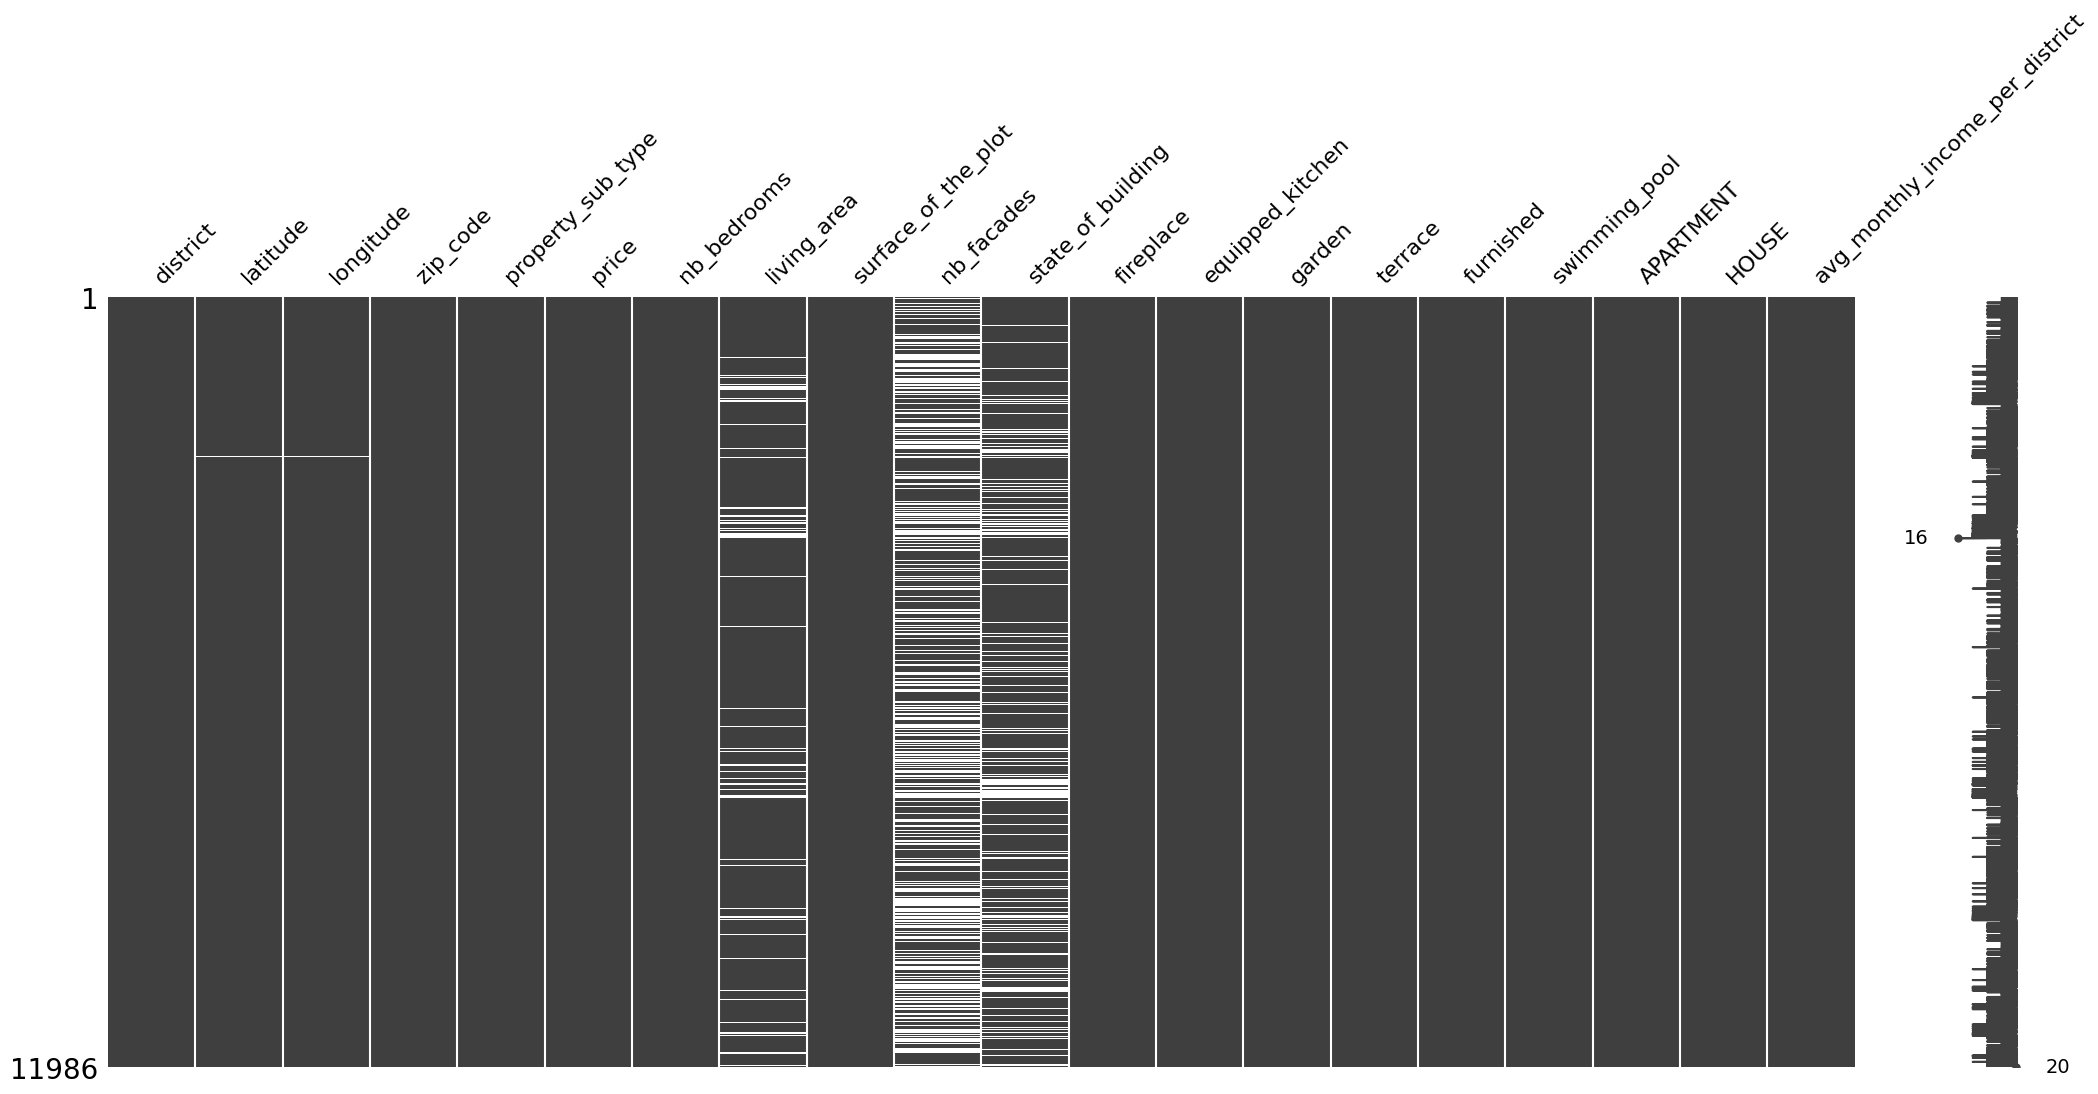

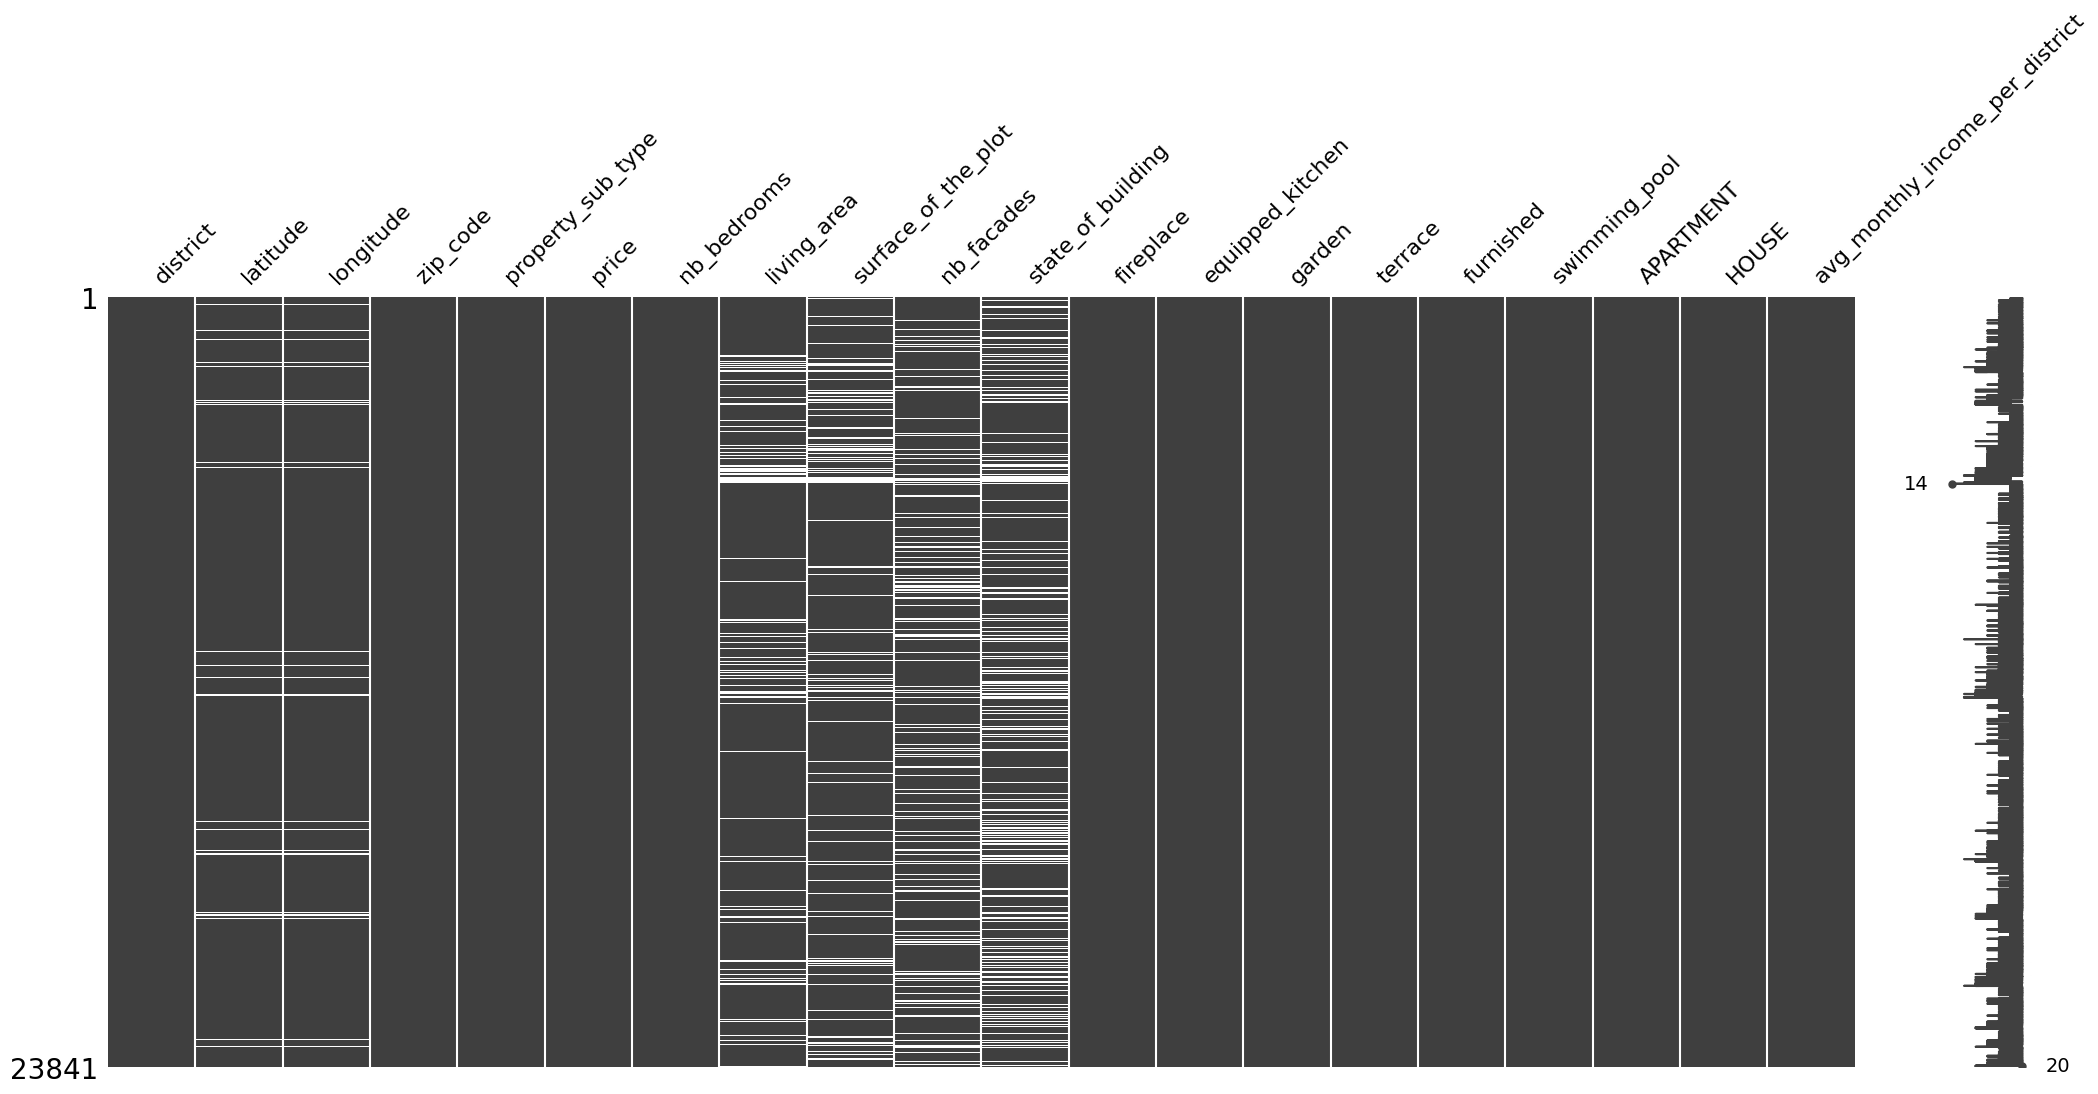

In [9]:
apartments = df_dummies[df_dummies["APARTMENT"] == 1]
houses = df_dummies[df_dummies["HOUSE"] == 1]
apartments["surface_of_the_plot"] = apartments["surface_of_the_plot"].fillna(value=0)
msno.matrix(apartments)
msno.matrix(houses)

numerical_columns = ['price']

def remove_outliers(data, columns):
    for col in columns:
        if col in data.columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

apartments = remove_outliers(apartments.copy(), numerical_columns)
houses = remove_outliers(houses.copy(), numerical_columns)

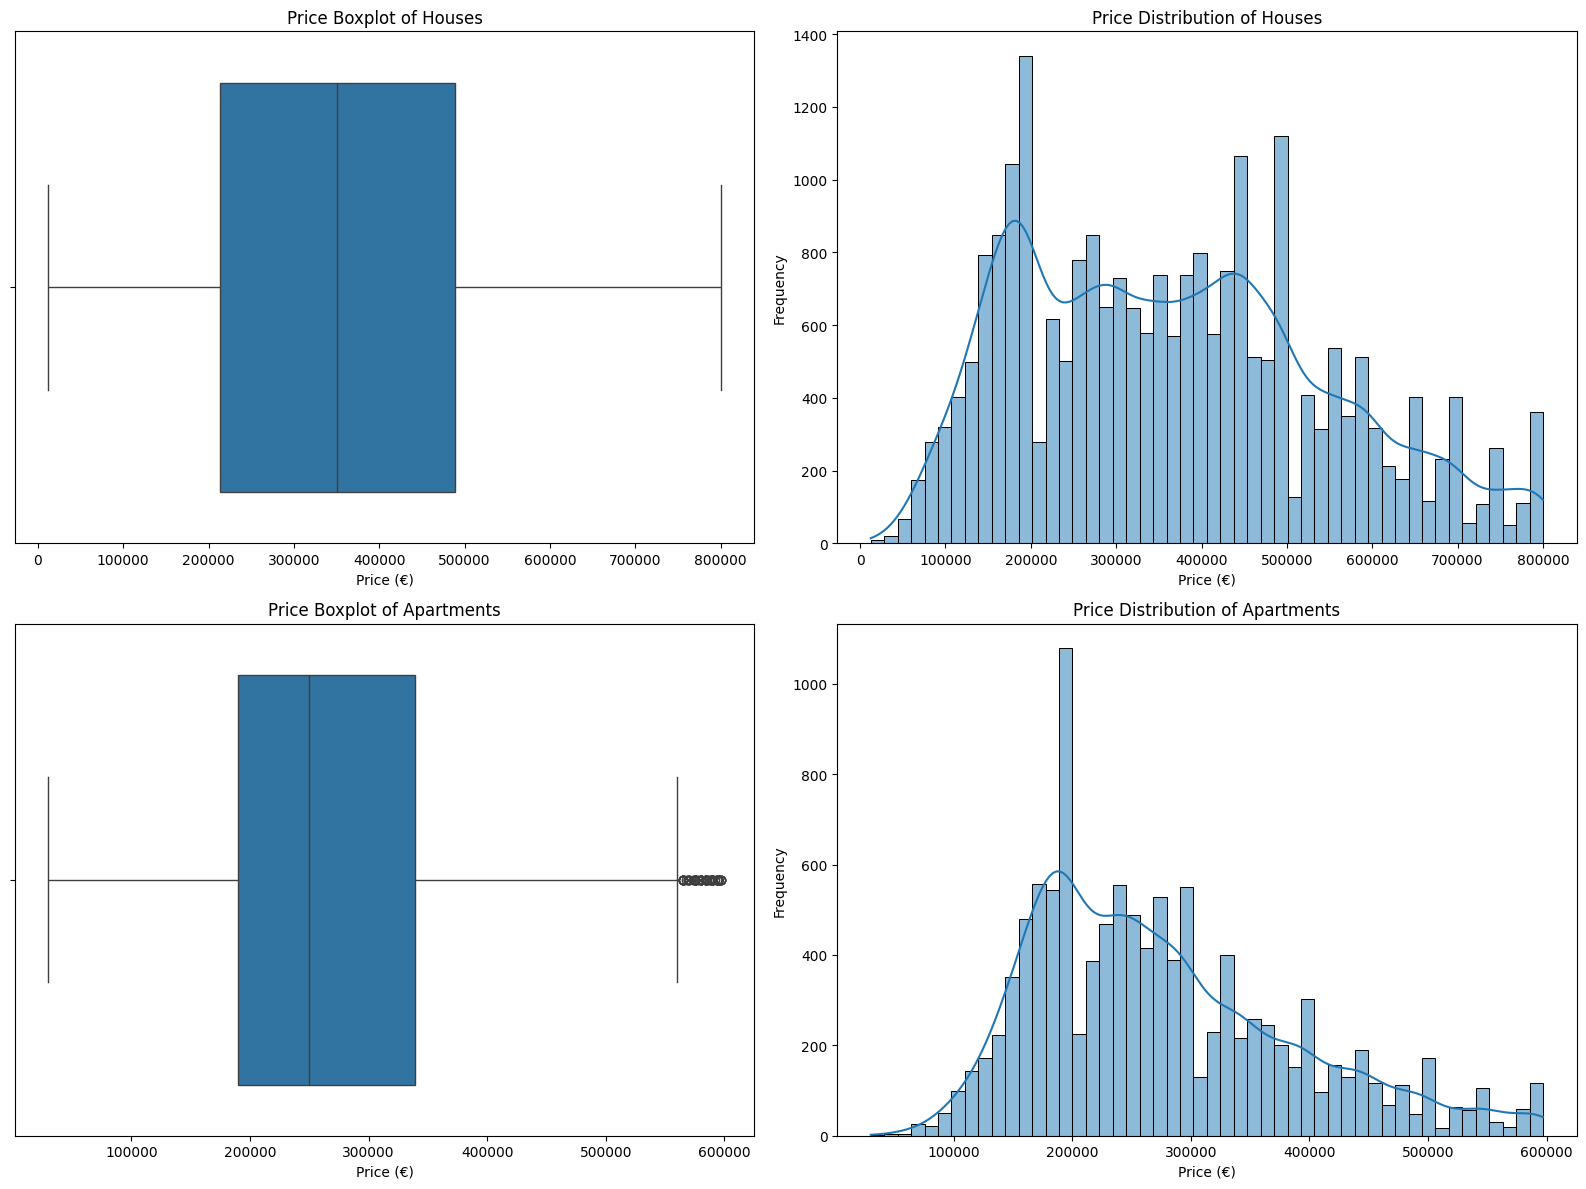

0.0
11454
0.0
23841
state_of_building                  4934
nb_facades                         4540
living_area                        2611
surface_of_the_plot                2461
longitude                           745
latitude                            745
garden                                0
HOUSE                                 0
APARTMENT                             0
swimming_pool                         0
furnished                             0
terrace                               0
district                              0
equipped_kitchen                      0
fireplace                             0
nb_bedrooms                           0
price                                 0
property_sub_type                     0
zip_code                              0
avg_monthly_income_per_district       0
dtype: int64
nb_facades                         4829
state_of_building                  2263
living_area                         854
longitude                            29
latitud

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# 1. Boxplot for Houses
sns.boxplot(x='price', data=houses, ax=axes[0, 0])
axes[0, 0].set_xlabel('Price (€)')
axes[0, 0].set_title('Price Boxplot of Houses')

# 2. Histogram for Houses
sns.histplot(houses['price'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Price Distribution of Houses')
axes[0, 1].set_xlabel('Price (€)')
axes[0, 1].set_ylabel('Frequency')

# 3. Boxplot for Apartments
sns.boxplot(x='price', data=apartments, ax=axes[1, 0])
axes[1, 0].set_xlabel('Price (€)')
axes[1, 0].set_title('Price Boxplot of Apartments')

# 4. Histogram for Apartments
sns.histplot(apartments['price'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Price Distribution of Apartments')
axes[1, 1].set_xlabel('Price (€)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(apartments[apartments['price'] > 1000000].shape[0] / apartments.shape[0] * 100)
print(apartments.shape[0])
print(houses[houses['price'] > 1000000].shape[0] /houses.shape[0] * 100 )
print(houses.shape[0])

high_priced_apartments = apartments[apartments['price'] > 1_000_000]
duplicate_prices = high_priced_apartments[high_priced_apartments['price'].duplicated(keep=False)]

print(houses.isna().sum().sort_values(ascending=False))
print(apartments.isna().sum().sort_values(ascending=False))


In [11]:
#Encode categorical values for state_of_the_building
states = ['To renovate','To be done up','To restore','Good','Just renovated','As new']
ordinal_encoder = OrdinalEncoder(categories=[states])

#For houses
state_h = houses['state_of_building']
state_not_null_h = state_h[state_h.notnull()].values.reshape(-1,1)
state_h_encoded = ordinal_encoder.fit_transform(state_not_null_h)
houses.loc[state_h.notnull(), 'state_of_building'] = np.squeeze(state_h_encoded)
#For apartments
state_a = apartments['state_of_building']
state_not_null_a = state_a[state_a.notnull()].values.reshape(-1,1)
state_a_encoded = ordinal_encoder.fit_transform(state_not_null_a)
apartments.loc[apartments["state_of_building"].notnull(), 'state_of_building'] = np.squeeze(state_a_encoded)

In [12]:
houses_dummies = pd.get_dummies(houses["district"])
houses = pd.concat([houses,houses_dummies], axis=1)
houses.drop('district', axis=1,inplace=True)

houses_dummies = pd.get_dummies(houses["property_sub_type"])
houses = pd.concat([houses,houses_dummies], axis=1)
houses.drop('property_sub_type', axis=1,inplace=True)

Index(['latitude', 'longitude', 'zip_code', 'price', 'nb_bedrooms',
       'living_area', 'surface_of_the_plot', 'nb_facades', 'state_of_building',
       'fireplace', 'equipped_kitchen', 'garden', 'terrace', 'furnished',
       'swimming_pool', 'APARTMENT', 'HOUSE',
       'avg_monthly_income_per_district', 'Alost', 'Anvers', 'Arlon', 'Ath',
       'Audenarde', 'Bastogne', 'Bruges', 'Bruxelles', 'Charleroi', 'Courtrai',
       'Dinant', 'Dixmude', 'Eeklo', 'Furnes', 'Gand', 'Hal-Vilvorde',
       'Hasselt', 'Huy', 'Liège', 'Louvain', 'Maaseik', 'Malines', 'Mons',
       'Mouscron', 'Namur', 'Neufchâteau', 'Nivelles', 'Ostende',
       'Philippeville', 'Roulers', 'Saint-Nicolas', 'Soignies', 'Termonde',
       'Thuin', 'Tielt', 'Tongres', 'Tournai', 'Turnhout', 'Verviers',
       'Virton', 'Waremme', 'Ypres', 'Apartment_Block', 'Bungalow', 'Castle',
       'Chalet', 'Country_Cottage', 'Exceptional_Property', 'Farmhouse',
       'House', 'Manor_House', 'Mansion', 'Mixed_Use_Building',
 

<Axes: >

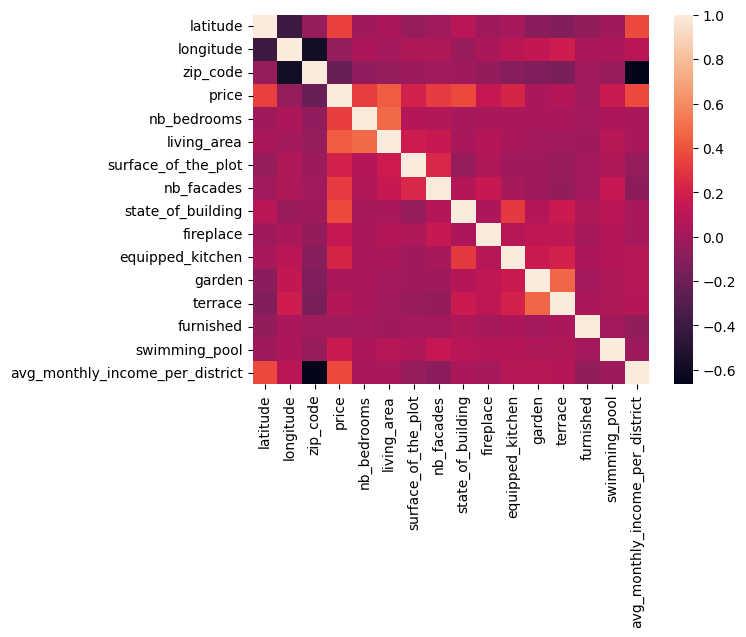

In [13]:
print(houses.columns)
houses_heatmap = houses[['latitude', 'longitude', 'zip_code', 'price', 'nb_bedrooms',
       'living_area', 'surface_of_the_plot', 'nb_facades', 'state_of_building',
       'fireplace', 'equipped_kitchen', 'garden', 'terrace', 'furnished',
       'swimming_pool','avg_monthly_income_per_district']]


sns.heatmap(houses_heatmap.corr())

In [14]:
# mode_imputer = SimpleImputer(strategy='most_frequent')

# state_encoded = houses['state_of_building'].values.reshape(-1, 1)

# state_imputed = mode_imputer.fit_transform(state_encoded)

# houses['state_of_building'] = state_imputed.squeeze()


<Axes: >

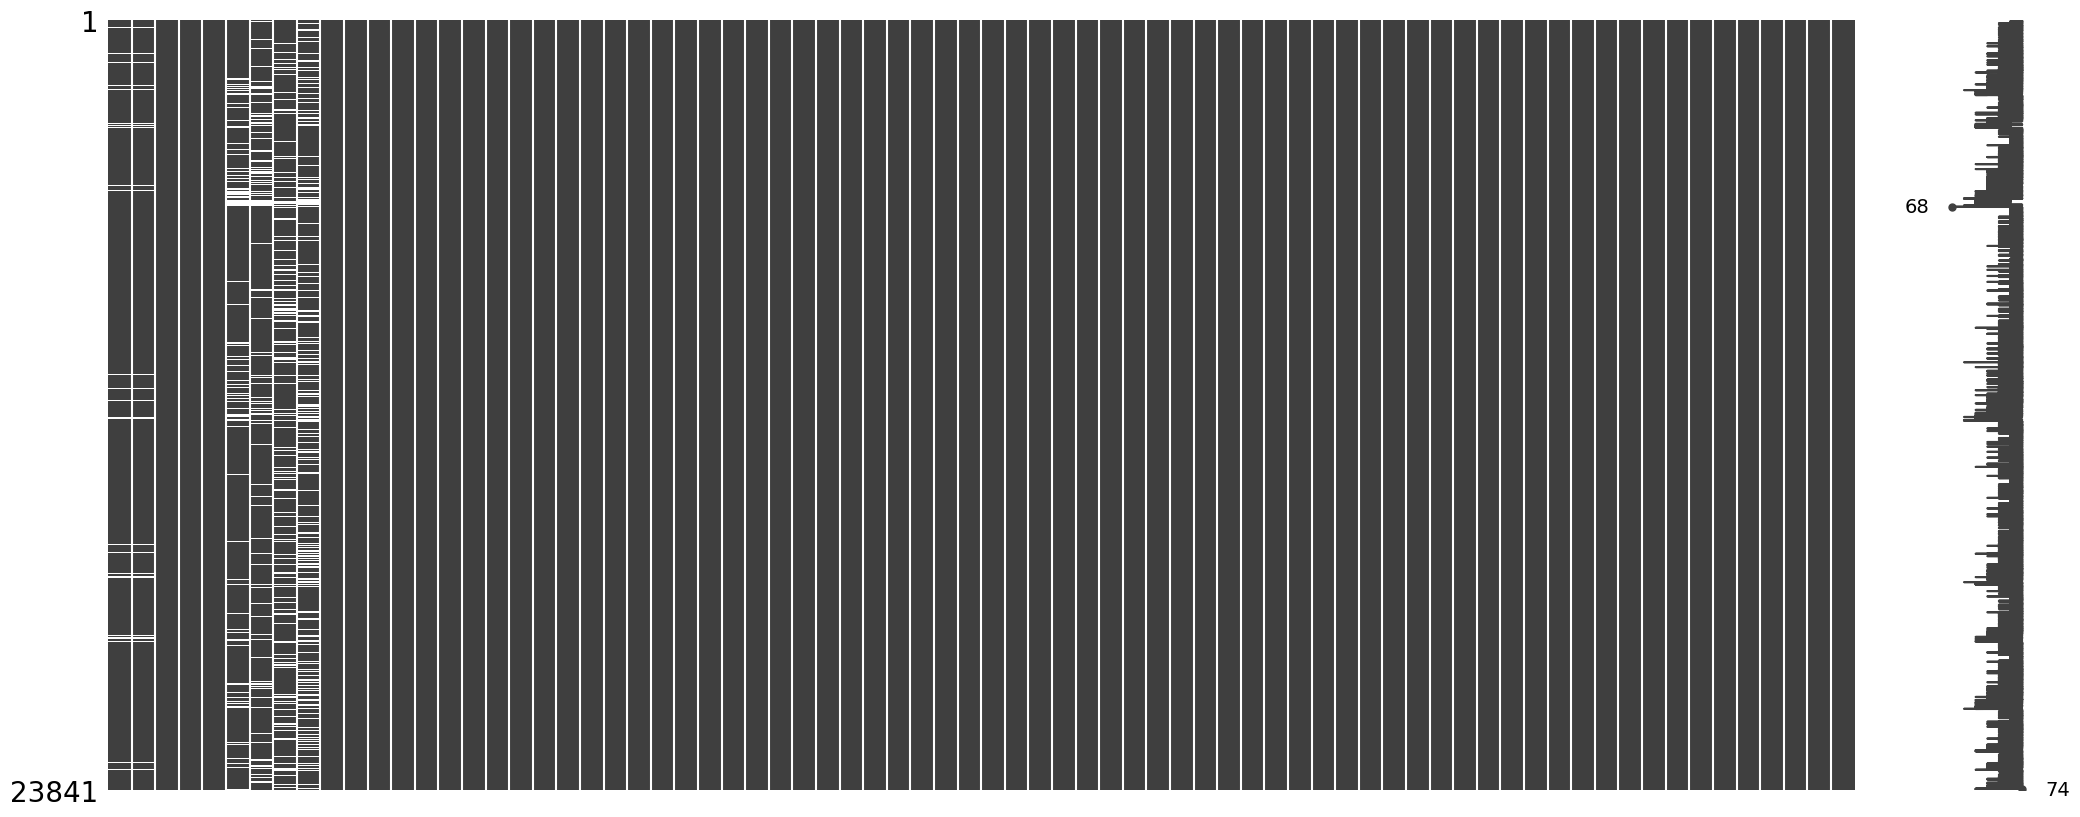

In [15]:
msno.matrix(houses)

In [16]:
houses.dropna(subset=['latitude','longitude','state_of_building','nb_facades','living_area','surface_of_the_plot'], inplace=True)
print(houses.isnull().sum().sort_values(ascending=False))

latitude     0
Turnhout     0
Tongres      0
Tielt        0
Thuin        0
            ..
Bruges       0
Bastogne     0
Audenarde    0
Ath          0
Villa        0
Length: 74, dtype: int64


In [17]:
houses.living_area.min()
houses.columns

Index(['latitude', 'longitude', 'zip_code', 'price', 'nb_bedrooms',
       'living_area', 'surface_of_the_plot', 'nb_facades', 'state_of_building',
       'fireplace', 'equipped_kitchen', 'garden', 'terrace', 'furnished',
       'swimming_pool', 'APARTMENT', 'HOUSE',
       'avg_monthly_income_per_district', 'Alost', 'Anvers', 'Arlon', 'Ath',
       'Audenarde', 'Bastogne', 'Bruges', 'Bruxelles', 'Charleroi', 'Courtrai',
       'Dinant', 'Dixmude', 'Eeklo', 'Furnes', 'Gand', 'Hal-Vilvorde',
       'Hasselt', 'Huy', 'Liège', 'Louvain', 'Maaseik', 'Malines', 'Mons',
       'Mouscron', 'Namur', 'Neufchâteau', 'Nivelles', 'Ostende',
       'Philippeville', 'Roulers', 'Saint-Nicolas', 'Soignies', 'Termonde',
       'Thuin', 'Tielt', 'Tongres', 'Tournai', 'Turnhout', 'Verviers',
       'Virton', 'Waremme', 'Ypres', 'Apartment_Block', 'Bungalow', 'Castle',
       'Chalet', 'Country_Cottage', 'Exceptional_Property', 'Farmhouse',
       'House', 'Manor_House', 'Mansion', 'Mixed_Use_Building',
 

In [18]:
from sklearn.metrics import root_mean_squared_error


# numerical_features = ['surface_of_the_plot','living_area','nb_facades']
# categorical_feature = ['state_of_building']
target = 'price'  

X_h = houses.drop(target, axis=1)
y_h = houses[target]
print(X_h['avg_monthly_income_per_district'])
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_h, y_h, test_size=0.2, random_state=42
)

# num_imputer = SimpleImputer(strategy='mean')
# mode_imputer = SimpleImputer(strategy='most_frequent')
# X_train_h_num = num_imputer.fit_transform(X_train_h[numerical_features])
# X_test_h_num = num_imputer.transform(X_test_h[numerical_features])

# X_train_h.loc[:, numerical_features] = X_train_h_num
# X_test_h.loc[:, numerical_features] = X_test_h_num

# X_train_h_cat = mode_imputer.fit_transform(X_train_h[categorical_feature].values.reshape(-1, 1))
# X_test_h_cat = mode_imputer.transform(X_test_h[categorical_feature].values.reshape(-1, 1))

# Assign imputed categorical values back to DataFrame
# X_train_h[categorical_feature] = X_train_h_cat
# X_test_h[categorical_feature] = X_test_h_cat

# scaler = RobustScaler()
# X_train_h[numerical_features] = scaler.fit_transform(X_train_h[numerical_features])
# X_test_h[numerical_features] = scaler.transform(X_test_h[numerical_features])

# model = LinearRegression()
# model.fit(X_train_h, y_train_h)

print(X_train_h)




0        3.780
1        3.836
2        3.836
3        3.893
4        3.836
         ...  
31434    4.347
31440    3.802
31447    3.771
31465    4.031
31467    3.562
Name: avg_monthly_income_per_district, Length: 12728, dtype: float64
        latitude  longitude  zip_code  nb_bedrooms  living_area  \
23157  51.067305   4.462735    2800.0          4.0        196.0   
10773  50.867311   4.309252    1082.0          2.0        106.0   
18108  50.710348   4.597015    1300.0          3.0        216.0   
29355  50.915576   4.210804    1730.0          3.0        211.0   
23374  51.202790   2.956814    8400.0          3.0        121.0   
...          ...        ...       ...          ...          ...   
28629  50.981620   4.558171    3190.0          3.0        325.0   
11612  50.610483   5.457978    4400.0          4.0        190.0   
11992  51.087887   2.939497    8680.0          4.0        216.0   
1248   49.811363   4.867107    5550.0          4.0        182.0   
17266  50.665207   4.235625  

In [19]:
# from torch.utils.data import TensorDataset,DataLoader,Dataset

# class Data(Dataset):
#     def __init__(self, X, y):
#         self.X = torch.from_numpy(X.values.astype(np.float32))
#         self.y = torch.from_numpy(y.values.astype(np.float32))
#         self.len = self.X.shape[0]
       
#     def __getitem__(self, index):
#         return self.X[index], self.y[index]
   
#     def __len__(self):
#         return self.len

# train_data = Data(X_train_h,y_train_h)
# train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
# test_data = Data(X_test_h, y_test_h)
# test_dataloader = DataLoader(dataset=test_data, batch_size=64, shuffle=True)
# for batch, (X, y) in enumerate(train_dataloader):
#     print(f"Batch: {batch+1}")
#     print(f"X shape: {X}")
#     print(f"y shape: {y.shape}")
#     break

# class LinearRegressionModel(nn.Module):
#     def __init__(self, in_features, out_features):
#         super().__init__()
#         self.linear = nn.Linear(in_feature, out_features)
    

In [20]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [21]:
from tensorflow.keras.layers import Dense,Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD,Adam


In [ ]:
def get_new_model(input_shape):    
    model = Sequential()
    model.add(Dense(64,activation='relu', input_shape=(input_shape,)))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(1))
    return model

In [23]:
new_num = ['surface_of_the_plot','living_area','nb_facades','nb_bedrooms','latitude','longitude']

print(X_train_h['avg_monthly_income_per_district'])

n_cols = len(X_train_h.columns)
early_stopping_monitor = EarlyStopping(patience=10)

for col in new_num:
    # fit on training data column
    scale = RobustScaler().fit(X_train_h[col].values.reshape(-1,1))
    # transform the training data column
    X_train_h[col] = scale.transform(X_train_h[col].values.reshape(-1,1))
    # transform the testing data column
    X_test_h[col] = scale.transform(X_test_h[col].values.reshape(-1,1))


23157    4.121
10773    4.748
18108    4.272
29355    4.406
23374    3.771
         ...  
28629    4.347
11612    3.836
11992    3.510
1248     3.134
17266    4.272
Name: avg_monthly_income_per_district, Length: 10182, dtype: float64


In [27]:
n_cols = len(X_train_h.columns)
early_stopping_monitor = EarlyStopping(patience=2)
lr_to_test = np.linspace(0.0001, 0.01, 20)
print(lr_to_test)

# Initialize variables to track the best score and learning rate
best_score = float('-inf')  # Assuming higher r2_score is better
best_lr = None

for lr in lr_to_test:
    # Get a fresh model
    model = get_new_model(n_cols)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error', metrics=['r2_score'])
    print(f"Learning rate used: {lr}")

    # Train the model
    history = model.fit(
        X_train_h, y_train_h, 
        batch_size=128, 
        epochs=50, 
        callbacks=[early_stopping_monitor],
        verbose=0  # Set to 0 to reduce output
    )
    
    # Get the best r2_score from training history
    max_r2 = max(history.history['r2_score'])
    
    print(f"Best r2_score for learning rate {lr}: {max_r2}")
    
    # Update the best score and learning rate if current is better
    if max_r2 > best_score:
        best_score = max_r2
        best_lr = lr

# Print the results
print(f"\nBest r2_score: {best_score}")
print(f"Achieved with learning rate: {best_lr}")

[0.0001     0.00062105 0.00114211 0.00166316 0.00218421 0.00270526
 0.00322632 0.00374737 0.00426842 0.00478947 0.00531053 0.00583158
 0.00635263 0.00687368 0.00739474 0.00791579 0.00843684 0.00895789
 0.00947895 0.01      ]
Learning rate used: 0.0001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.0001: -1.453000545501709
Learning rate used: 0.0006210526315789474


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.0006210526315789474: 0.521403431892395
Learning rate used: 0.0011421052631578948


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.0011421052631578948: 0.6063281893730164
Learning rate used: 0.0016631578947368423


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.0016631578947368423: 0.6297188401222229
Learning rate used: 0.0021842105263157894


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.0021842105263157894: 0.6397314071655273
Learning rate used: 0.0027052631578947366


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.0027052631578947366: 0.654151201248169
Learning rate used: 0.0032263157894736843


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.0032263157894736843: 0.6855700016021729
Learning rate used: 0.0037473684210526316


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.0037473684210526316: 0.6637400388717651
Learning rate used: 0.004268421052631579


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.004268421052631579: 0.6741030216217041
Learning rate used: 0.004789473684210527


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.004789473684210527: 0.6639083027839661
Learning rate used: 0.005310526315789474


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.005310526315789474: 0.693594217300415
Learning rate used: 0.005831578947368421


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.005831578947368421: 0.6656269431114197
Learning rate used: 0.006352631578947369


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.006352631578947369: 0.6966885328292847
Learning rate used: 0.0068736842105263166


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.0068736842105263166: 0.6921764612197876
Learning rate used: 0.007394736842105264


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.007394736842105264: 0.703387975692749
Learning rate used: 0.00791578947368421


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.00791578947368421: 0.6835936903953552
Learning rate used: 0.008436842105263158


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.008436842105263158: 0.6960513591766357
Learning rate used: 0.008957894736842106


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.008957894736842106: 0.6938647031784058
Learning rate used: 0.009478947368421052


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.009478947368421052: 0.7082427740097046
Learning rate used: 0.01


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,r2_score
  current = self.get_monitor_value(logs)


Best r2_score for learning rate 0.01: 0.6958138942718506

Best r2_score: 0.7082427740097046
Achieved with learning rate: 0.009478947368421052


In [ ]:
from sklearn.metrics import r2_score  # Import R-squared metric

y_pred = model.predict(X_test_h)
r2 = r2_score(y_test_h, y_pred)
print(f'R-squared (using r2_score): {r2:.4f}')

NameError: name 'model' is not defined